In [1]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import rasterio
import numpy as np
from tqdm import tqdm

In [3]:
# Таблица каналов спутника Sentinel-2A

# 1 | B02  | Blue, 492.4 nm (S2A), 492.1 nm (S2B)                 | 10m        |
# 2 | B03  | Green, 559.8 nm (S2A), 559.0 nm (S2B)                | 10m        |
# 3 | B04  | Red, 664.6 nm (S2A), 665.0 nm (S2B)                  | 10m        |
# 4 | B05  | Vegetation red edge, 704.1 nm (S2A), 703.8 nm (S2B)  | 20m        |
# 5 | B06  | Vegetation red edge, 740.5 nm (S2A), 739.1 nm (S2B)  | 20m        |
# 6 | B07  | Vegetation red edge, 782.8 nm (S2A), 779.7 nm (S2B)  | 20m        |
# 7 | B08  | NIR, 832.8 nm (S2A), 833.0 nm (S2B)                  | 10m        | 
# 8 | B8A  | Narrow NIR, 864.7 nm (S2A), 864.0 nm (S2B)           | 20m        |
# 9 | B11  | SWIR, 1613.7 nm (S2A), 1610.4 nm (S2B)               | 20m        |
# 10 | B12  | SWIR, 2202.4 nm (S2A), 2185.7 nm (S2B)               | 20m        |

In [4]:
def calculate_ndwi(green, nir):
    return (green - nir) / (green + nir + 1e-6)     


class Sentinel2DatasetCreator():
    def __init__(self, image_paths, mask_paths, patch_size=256, stride=128):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.patch_size = patch_size
        self.stride = stride
        self.patches = []
        
        # Устанавливаем фиксированный сид для воспроизводимости
        np.random.seed(42)
        
        # Предварительная загрузка и обработка изображений и масок
        all_channels = []
        for img_path, mask_path in tqdm(zip(image_paths, mask_paths), desc="Загрузка изображений и масок"):
            if img_path.endswith('.tif') and mask_path.endswith('.tif'):
                with rasterio.open(img_path) as src:
                    image = src.read([1, 2, 5, 7, 9])  # Берем только каналы B02, B03, B06, B08, B11, т.к они наиболее информативны для выявления водных объектов.
                    ndwi = calculate_ndwi(image[1], image[3]) # Считаем дополнительно индекс NDWI через зеленый (B03) и NIR (B08) каналы
                    image = np.concatenate([image, ndwi[np.newaxis, ...]], axis=0) # Добавляем NDWI в конец массива с изображением
                    image = np.transpose(image, (1, 2, 0))
                    all_channels.append(image)
                with rasterio.open(mask_path) as src:
                    mask = src.read(1)
            
            # Разделение изображения и маски на маленькие кусочки размером 256х256 пикс
            h, w = image.shape[:2]
            for i in tqdm(range(0, h - patch_size + 1, stride), desc="Создание патчей"):
                for j in range(0, w - patch_size + 1, stride):
                    image_patch = image[i:i+patch_size, j:j+patch_size, :]
                    mask_patch = mask[i:i+patch_size, j:j+patch_size]
                    self.patches.append((image_patch, mask_patch))
        
        # Расчет критериев нормализации для каждого канала по отдельности
        all_channels = np.concatenate([ch.reshape(-1, ch.shape[-1]) for ch in all_channels], axis=0)
        self.channel_means = np.mean(all_channels, axis=0)
        self.channel_stds = np.std(all_channels, axis=0)

        # Разделение данных на обучающую и тестовую выборки 
        # В представленных данных большое количество регионов без воды, поэтому 
        # чтобы обучение было более качественным - выберем только куски с наличием воды
        patches_with_1 = [p for p in self.patches if 1 in p[1]]
        patches_with_0 = [p for p in self.patches if 1 not in p[1]]
        
        np.random.shuffle(patches_with_1)
        np.random.shuffle(patches_with_0)
        
        # сформируем наши датасеты так, чтобы в трейне в 90% случаев были куски с водой
        # в тест закинем оставшиеся данные
        train_size_1 = int(len(patches_with_1) * 0.9)
        train_size_0 = int(train_size_1 / 9)  # 10% от количества патчей с маской 1
        
        self.train_patches = patches_with_1[:train_size_1] + patches_with_0[:train_size_0]
        self.test_patches = patches_with_1[train_size_1:]
        
        np.random.shuffle(self.train_patches)
        np.random.shuffle(self.test_patches)

        # Вывод статистики
        print(f"Количество файлов с масками в трейне: {len([p for p in self.train_patches if 1 in p[1]])}")
        print(f"Количество файлов без масок в трейне: {len([p for p in self.train_patches if 1 not in p[1]])}")
        print(f"Количество файлов с масками в тесте: {len([p for p in self.test_patches if 1 in p[1]])}")
        print(f"Количество файлов без масок в тесте: {len([p for p in self.test_patches if 1 not in p[1]])}")
        print(f"Общее количество файлов: {len(self.train_patches) + len(self.test_patches)}")

    def get_train_test_data(self):
        return self.train_patches, self.test_patches
    
    def get_normalization_params(self):
        return {'means': self.channel_means, 'stds': self.channel_stds}
    
np.random.seed(42)

train_image_paths = [f'./train/images/{image}' for image in os.listdir('./train/images')]
train_mask_paths = [f'./train/masks/{mask}' for mask in os.listdir('./train/masks')]

train_dataset = Sentinel2DatasetCreator(train_image_paths, train_mask_paths)
train_patches, test_patches = train_dataset.get_train_test_data()
normalization_params = train_dataset.get_normalization_params()


Создание патчей: 100%|██████████| 33/33 [00:00<00:00, 18067.10it/s]
Загрузка изображений и масок: 9it [00:15,  1.74s/it]


Количество файлов с масками в трейне: 7295
Количество файлов без масок в трейне: 810
Количество файлов с масками в тесте: 811
Количество файлов без масок в тесте: 0
Общее количество файлов: 8916


In [5]:
# Выведем параметры нормализации по каналам, чтобы не потерялись :)
normalization_params

{'means': array([ 379.32272921,  559.31295475, 1681.15083572, 2066.72689497,
        1774.60624368,   27.08799462]),
 'stds': array([270.54608327, 267.30903042, 687.08251987, 916.49339797,
        666.09729757,  12.64723763])}

In [6]:
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_training_augmentation():
    return A.Compose([
        A.RandomRotate90(p=0.5),
        A.Flip(p=0.5),
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
        A.OneOf([
            A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
            A.GridDistortion(p=0.5),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=0.5),
        ], p=0.3),
        # A.OneOf([
        #     A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        #     A.MultiplicativeNoise(multiplier=[0.9, 1.1], per_channel=True, p=0.5),
        # ], p=0.3),
        # A.OneOf([
        #     A.ChannelShuffle(p=0.5),
        #     A.ChannelDropout(channel_drop_range=(1, 1), fill_value=0, p=0.5),
        # ], p=0.3),
        # A.Lambda(image=channel_specific_augmentation, mask=None, p=1.0),
        # # ToTensorV2(),
    ], additional_targets={'mask': 'mask'})

def channel_specific_augmentation(image, **kwargs):
    image = image.astype(np.float32)
    
    augmented_channels = []
    for i in range(image.shape[2]):
        channel = image[:, :, i]
        
        if i in [0, 1, 2]:  # Видимые каналы (B02, B03, B04)
            aug = A.Compose([
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                A.RandomGamma(gamma_limit=(80, 120), p=0.5),
            ])
        elif i in [3, 4]:  # Каналы красного края (B05, B06)
            aug = A.Compose([
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
            ])
        else:  # NIR и SWIR каналы (B07, B08, B8A, B11, B12)
            aug = A.Compose([
                A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),
                # A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
            ])
        
        augmented_channel = aug(image=channel[:,:,np.newaxis])['image']
        augmented_channels.append(augmented_channel[:,:,0])
    
    augmented_image = np.stack(augmented_channels, axis=-1)
    
    augmented_image = np.nan_to_num(augmented_image, nan=0.0)
    
    return augmented_image.astype(np.float32)

# Аугментируем данные
train_transform = get_training_augmentation()

/home/user1/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_691587/2900777933.py:8: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),
/tmp/ipykernel_691587/2900777933.py:12: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),


In [7]:
#Создаем класс датасета уже непосредственно для обучения

class Sentinel2Dataset(Dataset):
    def __init__(self, patches, normalization_params, transform=None):
        self.patches = patches
        self.normalization_params = normalization_params
        self.transform = transform

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        image_patch, mask_patch = self.patches[idx]
        
        # Нормализация
        image_patch = (image_patch - self.normalization_params['means']) / self.normalization_params['stds']
        
        # Убедимся, что изображение имеет тип float32
        image_patch = image_patch.astype(np.float32)
        
        if self.transform:
            augmented = self.transform(image=image_patch, mask=mask_patch)
            image_patch = augmented['image']
            mask_patch = augmented['mask']
        

        image_patch = torch.from_numpy(image_patch).float()
        mask_patch = torch.from_numpy(mask_patch).long()
        return image_patch, mask_patch

In [8]:
# Создаем датасеты и даталоадеры для обучения и теста
train_dataset = Sentinel2Dataset(train_patches, normalization_params, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = Sentinel2Dataset(test_patches, normalization_params, transform=None)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [9]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import SegformerForSemanticSegmentation, SegformerConfig
from transformers import AdamW, get_linear_schedule_with_warmup
from datasets import Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score
from torch.utils.tensorboard import SummaryWriter

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [10]:
# Создаем модель UNET для сегментации изображений.
# Мы немного поэксперементировали, и по итогам эксперементов добавили в классический UNET блоки внимания для того чтобы
# фокусироваться на наиболее информативных частях изображения, быстрее сходиться и показывать более лучшую сегментацию.

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, in_channels):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 8, kernel_size=1),
            nn.BatchNorm2d(in_channels // 8),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 8, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        attention_map = self.attention(x)
        return x * attention_map

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(64, 128)
        )
        self.down2 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(128, 256)
        )
        self.down3 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(256, 512)
        )
        self.down4 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(512, 1024)
        )
        self.down5 = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(1024, 2048)
        )

        self.attention1 = AttentionBlock(2048)
        self.attention2 = AttentionBlock(1024)
        self.attention3 = AttentionBlock(512)
        self.attention4 = AttentionBlock(256)
        self.attention5 = AttentionBlock(128)

        self.up1 = nn.ConvTranspose2d(2048, 1024, 2, stride=2)
        self.up_conv1 = DoubleConv(2048, 1024)
        self.up2 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.up_conv2 = DoubleConv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.up_conv3 = DoubleConv(512, 256)
        self.up4 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up_conv4 = DoubleConv(256, 128)
        self.up5 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up_conv5 = DoubleConv(128, 64)
        
        self.outc = nn.Conv2d(64, n_classes, 1)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)
        
        x6 = self.attention1(x6)
        x6 = self.dropout(x6)
        
        x = self.up1(x6)
        x5 = self.attention2(x5)
        x = torch.cat([x, x5], dim=1)
        x = self.up_conv1(x)
        x = self.dropout(x)
        
        x = self.up2(x)
        x4 = self.attention3(x4)
        x = torch.cat([x, x4], dim=1)
        x = self.up_conv2(x)
        x = self.dropout(x)
        
        x = self.up3(x)
        x3 = self.attention4(x3)
        x = torch.cat([x, x3], dim=1)
        x = self.up_conv3(x)
        
        x = self.up4(x)
        x2 = self.attention5(x2)
        x = torch.cat([x, x2], dim=1)
        x = self.up_conv4(x)
        
        x = self.up5(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up_conv5(x)
        
        logits = self.outc(x)
        return logits

# Инициализация модели
model = UNet(n_channels=6, n_classes=2)
model.load_state_dict(torch.load('model_3.pth'))

import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss

# Инициализируем оптимизатор и функцию потерь
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = FocalLoss(alpha=0.25, gamma=2)

# Планировщик скорости обучения
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

num_epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

UNet(
  (inc): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (

In [11]:
# Обучение модели
import datetime

# Функция для вычисления метрики IoU
def calculate_iou(pred, target):
    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

run_id = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

criterion = nn.CrossEntropyLoss()

# Настройка TensorBoard
writer = SummaryWriter(log_dir=f'./logs/run_{run_id}')

# Обучение модели
for epoch in range(0,50,1):
    model.train()
    total_loss = 0
    total_iou = 0
    
    for batch_idx, (images, masks) in enumerate(tqdm(train_loader, desc=f"Эпоха {epoch+1}/{num_epochs}")):
        inputs, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()

        inputs = inputs.permute(0, 3, 1, 2)
        
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Вычисление IoU
        pred_masks = outputs.argmax(dim=1)
        iou = calculate_iou(pred_masks, masks)
        total_iou += iou.item()
        
        # Запись метрик для каждого батча в TensorBoard
        global_step = epoch * len(train_loader) + batch_idx
        writer.add_scalar('loss/train', loss.item(), global_step)
        writer.add_scalar('iou/train', iou.item(), global_step)
        
        # Добавление пар картинка-маска в тензорборд каждые 50 батчей для контроля за обучением
        if batch_idx % 50 == 0:
            plt.close(fig)
            
            # Валидация каждые 50 батчей
            model.eval()
            val_loss = 0
            val_iou = 0
            
            with torch.no_grad():
                for val_batch_idx, (val_images, val_masks) in enumerate(test_loader):
                    val_inputs, val_masks = val_images.to(device), val_masks.to(device)
                    val_inputs = val_inputs.permute(0, 3, 1, 2)
                    val_outputs = model(val_inputs)
                    val_loss += criterion(val_outputs, val_masks).item()
                    val_pred_masks = val_outputs.argmax(dim=1)
                    val_iou += calculate_iou(val_pred_masks, val_masks).item()
                    
                    if val_batch_idx == 0:
                        # Визуализация первого батча валидации
                        val_img = val_inputs[0].cpu().permute(1, 2, 0).numpy()
                        val_true_mask = val_masks[0].cpu().numpy()
                        val_pred_mask = val_pred_masks[0].cpu().numpy()
                        
                        val_img = (val_img - val_img.min()) / (val_img.max() - val_img.min())
                        
                        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
                        ax1.imshow(val_img[:, :, :3])
                        ax1.set_title('Входное изображение (Валидация)')
                        ax1.axis('off')
                        
                        ax2.imshow(val_true_mask, cmap='gray')
                        ax2.set_title('Истинная маска (Валидация)')
                        ax2.axis('off')
                        
                        ax3.imshow(val_pred_mask, cmap='gray')
                        ax3.set_title('Предсказанная маска (Валидация)')
                        ax3.axis('off')
                        
                        writer.add_figure(f'Изображение-Маска (Валидация)/Эпоха {epoch+1}, Батч {batch_idx}', fig, global_step)
                        plt.close(fig)
            
            avg_val_loss = val_loss / len(test_loader)
            avg_val_iou = val_iou / len(test_loader)
            
            writer.add_scalar('loss/val', avg_val_loss, global_step)
            writer.add_scalar('iou/val', avg_val_iou, global_step)
            
            print(f"Валидация - Эпоха {epoch+1}, Батч {batch_idx}, loss: {avg_val_loss:.4f}, IoU: {avg_val_iou:.4f}")
            
            model.train()
    
    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    
    print(f"Эпоха {epoch+1}/{num_epochs}, loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")
    
    # Запись метрик в TensorBoard
    writer.add_scalar('mean_loss/train', avg_loss, epoch)
    writer.add_scalar('mean_iou/train', avg_iou, epoch)

writer.close()


Эпоха 1/50:   0%|          | 0/254 [00:00<?, ?it/s]

Эпоха 1/50:   0%|          | 1/254 [00:30<2:07:01, 30.13s/it]

Валидация - Эпоха 1, Батч 0, loss: 0.0371, IoU: 0.0000, F1: 0.9051


Эпоха 1/50:  20%|██        | 51/254 [02:15<33:00,  9.75s/it] 

Валидация - Эпоха 1, Батч 50, loss: 0.0054, IoU: 0.2293, F1: 0.9809


Эпоха 1/50:  40%|███▉      | 101/254 [04:00<24:20,  9.54s/it]

Валидация - Эпоха 1, Батч 100, loss: 0.0037, IoU: 0.2230, F1: 0.9820


Эпоха 1/50:  56%|█████▋    | 143/254 [05:07<03:58,  2.15s/it]


KeyboardInterrupt: 

In [34]:
# Сохраняем получившуюся модель
torch.save(model.state_dict(), 'model_3.pth')
print("Модель сохранена в файл 'model.pth'")

Модель сохранена в файл 'model.pth'


In [28]:
# Загружаем модель
model = UNet(n_channels=6, n_classes=2)
model.load_state_dict(torch.load('model_2.pth'))
model.eval()  

print("Модель UNet успешно загружена из файла 'model.pth'")

model.to('cuda')
pass

Модель UNet успешно загружена из файла 'model_2.pth'


/tmp/ipykernel_651834/2717095179.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_2.pth'))


Обработка окон:   0%|          | 0/9 [00:00<?, ?it/s]

Обработка окон: 100%|██████████| 9/9 [00:00<00:00, 54.88it/s]


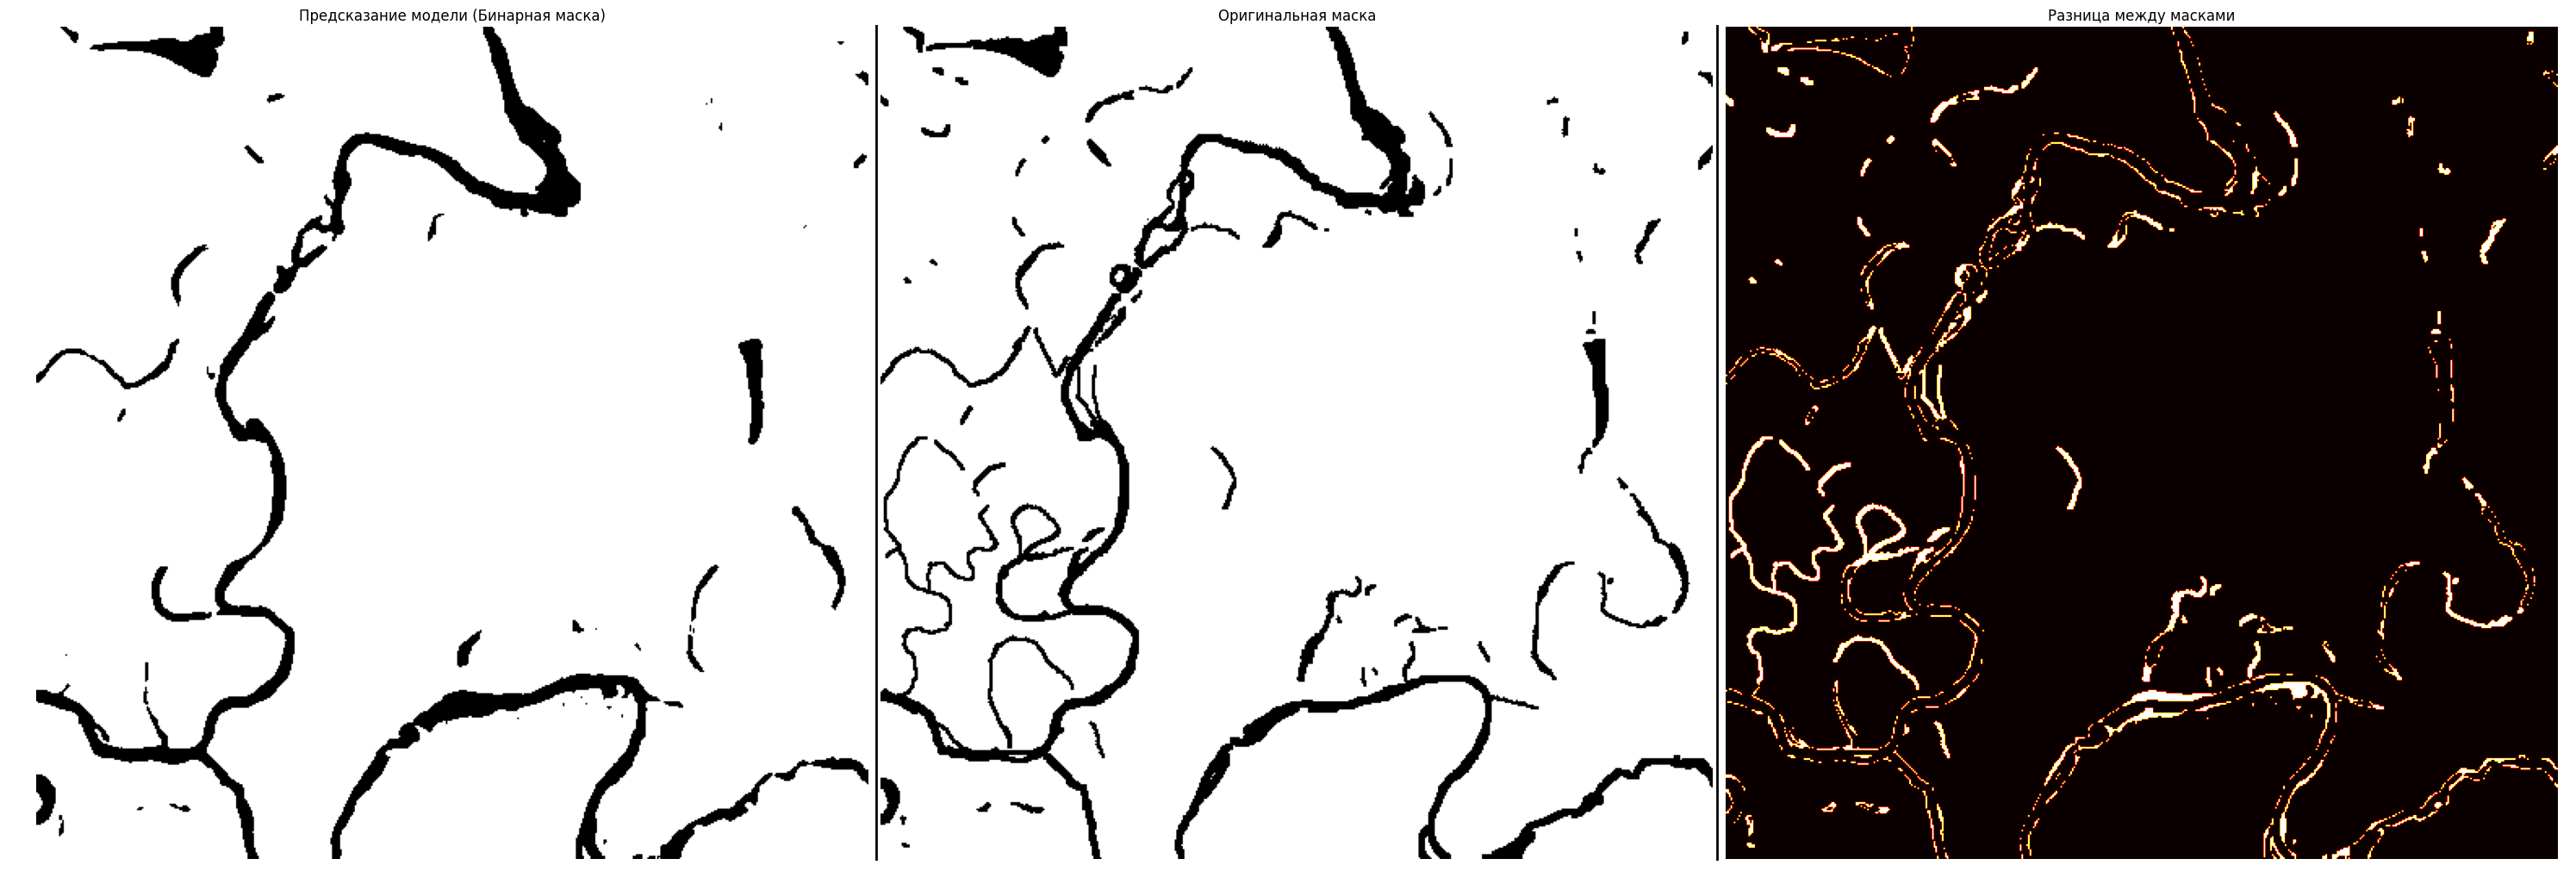

F1 Score: 0.7566
IoU Score: 0.6085


In [35]:
import rasterio
import numpy as np
import torch
from torch.nn.functional import pad
import matplotlib.pyplot as plt
from tqdm import tqdm

# Разбиваем изображение на куски размером 256х256 с шагом 128 и строим маски для каждого куска по отдельности

def predict_large_image(model, image_path, window_size=256, stride=128, batch_size=64):
    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 5, 7, 9])  # Берем только каналы B02, B03, B06, B08, B11
        height, width = image.shape[1], image.shape[2]
        
        # Расчет NDWI
        ndwi = calculate_ndwi(image[1], image[3])
        image = np.concatenate([image, ndwi[np.newaxis, ...]], axis=0)
        
        # Нормализация
        means = np.array(normalization_params['means'])[:, np.newaxis, np.newaxis]
        stds = np.array(normalization_params['stds'])[:, np.newaxis, np.newaxis]
        image = (image - means) / stds
        
        # Создаем выходную маску
        prediction = np.zeros((height, width), dtype=np.float32)
        counts = np.zeros((height, width), dtype=np.float32)

    # Переводим модель в режим оценки и на нужное устройство
    model.eval()
    device = next(model.parameters()).device

    windows = []
    positions = []
    total_windows = ((height - window_size) // stride + 1) * ((width - window_size) // stride + 1)
    
    with tqdm(total=total_windows, desc="Обработка окон") as pbar:
        for y in range(0, height - window_size + 1, stride):
            for x in range(0, width - window_size + 1, stride):
                window = image[:, y:y+window_size, x:x+window_size]
                windows.append(window)
                positions.append((y, x))
                
                if len(windows) == batch_size:
                    batch = torch.from_numpy(np.array(windows)).float().to(device)
                    batch = batch.permute(0, 1, 2, 3)
                    
                    with torch.no_grad():
                        output = model(batch)
                        output = torch.argmax(output, dim=1)  
                    
                    for (y, x), pred in zip(positions, output):
                        prediction[y:y+window_size, x:x+window_size] += pred.cpu().numpy()
                        counts[y:y+window_size, x:x+window_size] += 1
                    
                    windows = []
                    positions = []
                    
                    pbar.update(batch_size)
    
        if windows:
            batch = torch.from_numpy(np.array(windows)).float().to(device)
            batch = batch.permute(0, 1, 2, 3)
            with torch.no_grad():
                output = model(batch)
                output = torch.argmax(output, dim=1)
            for (y, x), pred in zip(positions, output):
                prediction[y:y+window_size, x:x+window_size] += pred.cpu().numpy()
                counts[y:y+window_size, x:x+window_size] += 1
            
            pbar.update(len(windows))

    prediction = np.divide(prediction, counts, where=counts != 0)
    prediction = np.round(prediction).astype(int)
    
    return prediction

image_path = 'train/images/9_1.tif'
mask_path = 'train/masks/9_1.tif'
prediction = predict_large_image(model, image_path)

original_mask = rasterio.open(mask_path).read(1)

difference = np.abs(prediction - original_mask)

# Вычисление метрик F1 и IoU
from sklearn.metrics import f1_score, jaccard_score

f1 = f1_score(original_mask.flatten(), prediction.flatten(), average='binary')
iou = jaccard_score(original_mask.flatten(), prediction.flatten(), average='binary')

# Визуализация результата
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

images = [prediction, original_mask, difference]
titles = ['Предсказание модели (Бинарная маска)', 'Оригинальная маска', 'Разница между масками']
cmaps = ['binary', 'binary', 'hot']

for ax, img, title, cmap in zip(axes, images, titles, cmaps):
    ax.imshow(img, cmap=cmap)
    ax.set_title(title)
    ax.axis('off')

for i in range(1, 3):
    fig.add_subplot(111, frameon=False)
    plt.axvline(x=i/3, color='black', linewidth=2)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.tight_layout()
plt.show()

print(f"F1 Score: {f1:.4f}")
print(f"IoU Score: {iou:.4f}")
